[View in Colaboratory](https://colab.research.google.com/github/Tejas163/DataScience-Deep-Learning-course/blob/master/Object_Recognition.ipynb)

In [0]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

In [37]:
!pip install --no-cache-dir -I pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 22.7MB/s 
    100% |████████████████████████████████| 112kB 12.2MB/s 
  Running setup.py install for olefile ... - done


In [0]:
import PIL.Image

In [0]:
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = "data/dogscats/"
sz=224

In [17]:
torch.cuda.is_available()

True

In [18]:
!ls $PATH

models	sample	test1  train  valid


In [19]:
torch.backends.cudnn.enabled

True

In [20]:
os.listdir(PATH)

['valid', 'sample', 'models', 'test1', 'train']

In [22]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [24]:
files=os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.6379.jpg',
 'cat.10547.jpg',
 'cat.6662.jpg',
 'cat.9960.jpg',
 'cat.631.jpg']

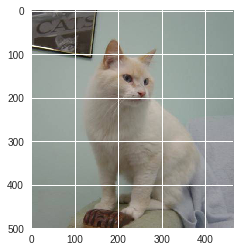

In [39]:
img=plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [40]:
img.shape

(500, 465, 3)

In [41]:
img[:4,:4]

array([[[ 75,  74,  70],
        [ 84,  83,  79],
        [ 95,  94,  90],
        [102, 101,  97]],

       [[ 83,  82,  78],
        [ 90,  89,  85],
        [ 99,  98,  94],
        [103, 102,  98]],

       [[ 86,  85,  83],
        [ 93,  92,  90],
        [101, 100,  98],
        [103, 102, 100]],

       [[ 80,  78,  79],
        [ 87,  85,  86],
        [ 96,  94,  95],
        [100,  98,  99]]], dtype=uint8)

#Training the first model using pretrained model


In [42]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 92977005.05it/s]


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.043607   0.031909   0.9885    
    1      0.046351   0.02843    0.989     



[array([0.02843]), 0.989]

In [43]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
data.classes

['cats', 'dogs']

In [45]:
#prediction
log_pred=learn.predict()
log_pred.shape

(2000, 2)

In [46]:
log_pred[:10]

array([[ -0.     , -12.51448],
       [ -0.00385,  -5.56249],
       [ -0.02818,  -3.58316],
       [ -0.47231,  -0.97699],
       [ -0.00017,  -8.6783 ],
       [ -0.00011,  -9.09047],
       [ -0.00071,  -7.24672],
       [ -0.00001, -11.35573],
       [ -0.00015,  -8.77342],
       [ -0.00009,  -9.36716]], dtype=float32)

In [0]:
pred=np.argmax(log_pred,axis=1)
pred_d=np.exp(log_pred[:,1])

In [0]:
def random_mask(mask):
  return np.random.choice(np.where(mask)[0],4,replace=False)

def rand_correct(is_corr):
  return random_mask((pred==data.val_y)==is_corr)


In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(Image.open(PATH+ds.fnames[idx]))


In [0]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [pred_d[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


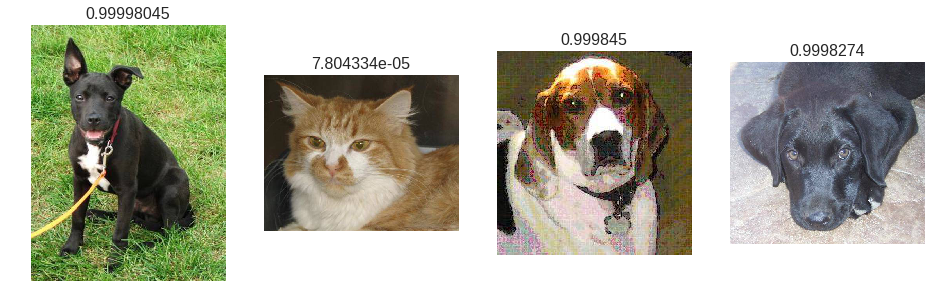

In [68]:
plot_val_with_title(rand_correct(True), "Correctly classified")

Incorrectly classified


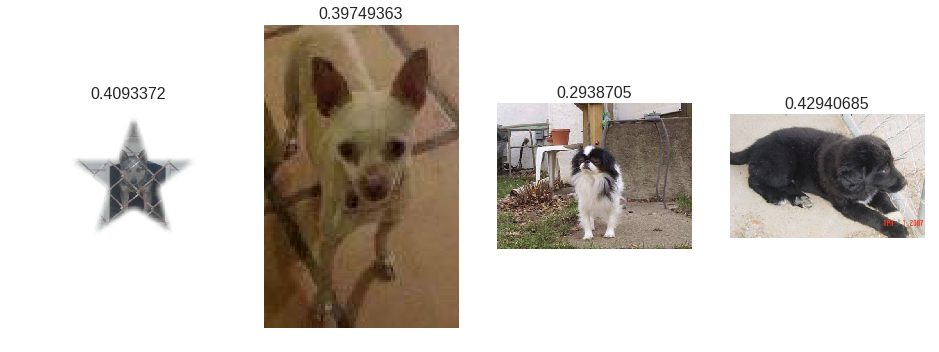

In [70]:
plot_val_with_title(rand_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * pred_d[idxs])[:4]]

def most_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((pred == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


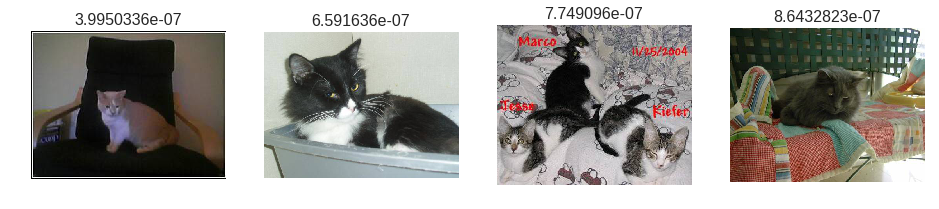

In [83]:
plot_val_with_title(most_correct(0, True), "Most correct cats")

Most correct dogs


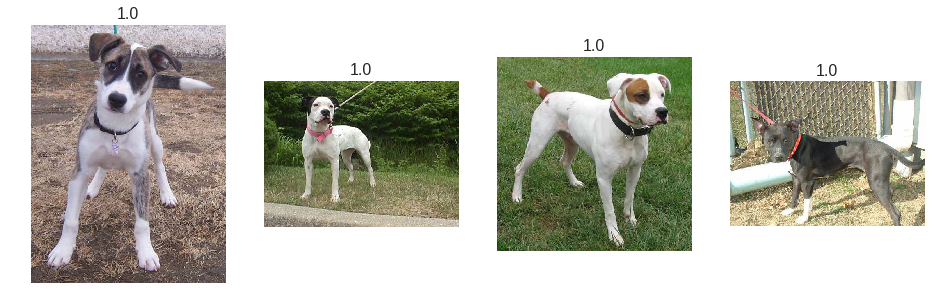

In [85]:
plot_val_with_title(most_correct(1, True), "Most correct dogs")

Most incorrect cats


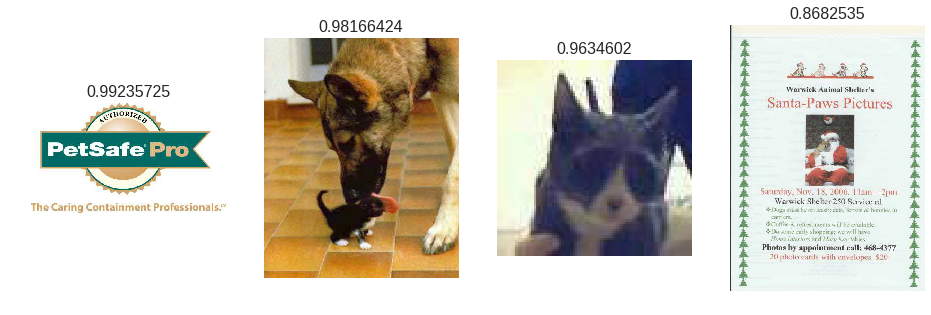

In [86]:
plot_val_with_title(most_correct(0, False), "Most incorrect cats")

Most incorrect dogs


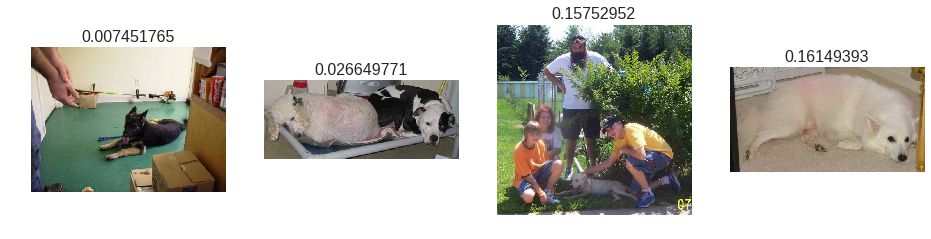

In [87]:
plot_val_with_title(most_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


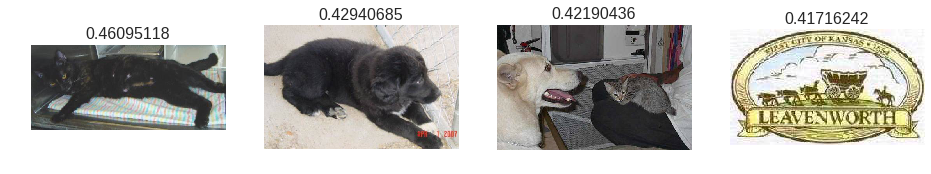

In [88]:
most_uncertain = np.argsort(np.abs(pred_d -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [91]:
lrf=learn.lr_find()                    #finds the learning rate

 84%|████████▍ | 303/360 [00:07<00:01, 41.10it/s, loss=0.439]


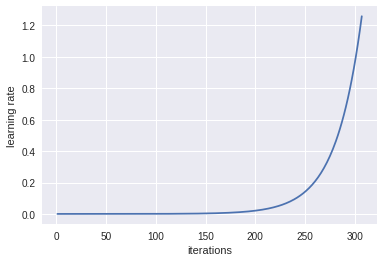

In [92]:
learn.sched.plot_lr()

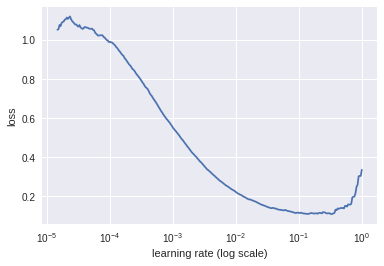

In [93]:
learn.sched.plot()

In [0]:
#using transform time augmentation
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

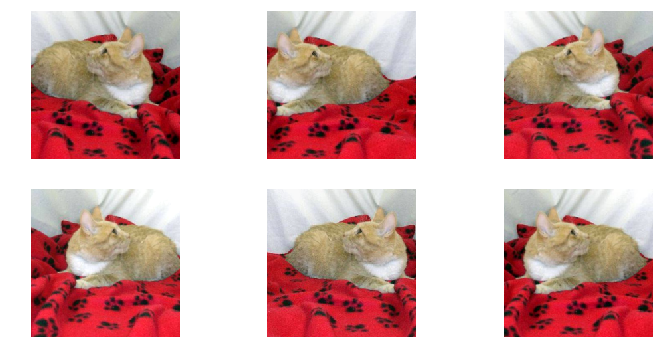

In [97]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [100]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.044667   0.028709   0.989     
    1      0.033195   0.024528   0.989     



[array([0.02453]), 0.989]

In [0]:
learn.precompute=False

In [102]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.037136   0.024802   0.991     
    1      0.041145   0.023993   0.9905    
    2      0.038818   0.024119   0.991     



[array([0.02412]), 0.991]

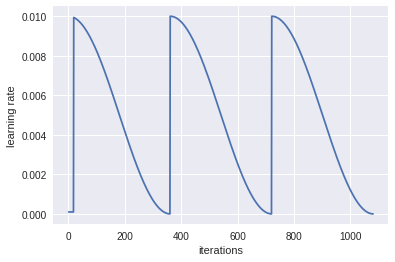

In [106]:
learn.sched.plot_lr()

In [0]:
#save the last layer
learn.save('224_lastlayer')

In [0]:
#load the saved last layer
learn.load('224_lastlayer')

In [0]:
#unfreeze remaining layers
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [112]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.054377   0.025807   0.9895    
    1      0.044231   0.022213   0.9905    
    2      0.031113   0.0189     0.9925    
    3      0.030071   0.017499   0.9935    
    4      0.025762   0.021118   0.993     
  4%|▍         | 14/360 [00:18<07:37,  1.32s/it, loss=0.0236]

KeyboardInterrupt: ignored

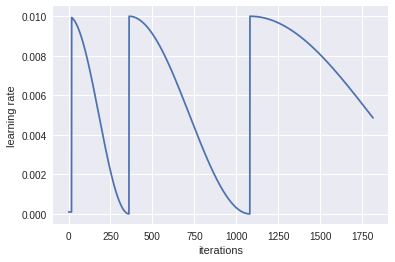

In [113]:
learn.sched.plot_lr()

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

In [117]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [118]:
accuracy_np(probs, y)

0.9935

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  8 992]]


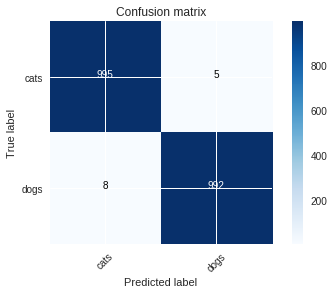

In [121]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


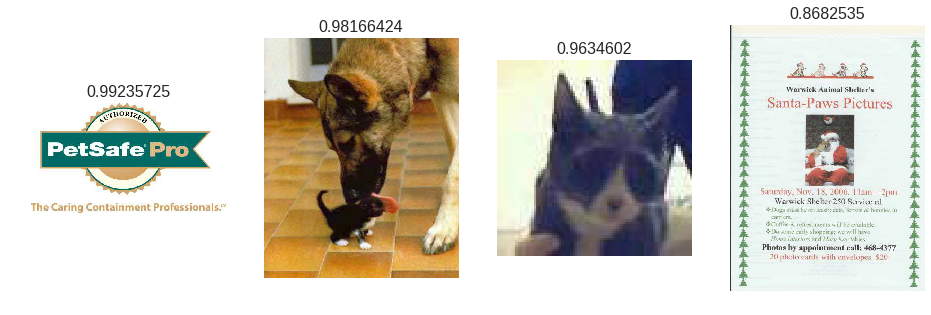

In [122]:
plot_val_with_title(most_correct(0, False), "Most incorrect cats")

Most incorrect dogs


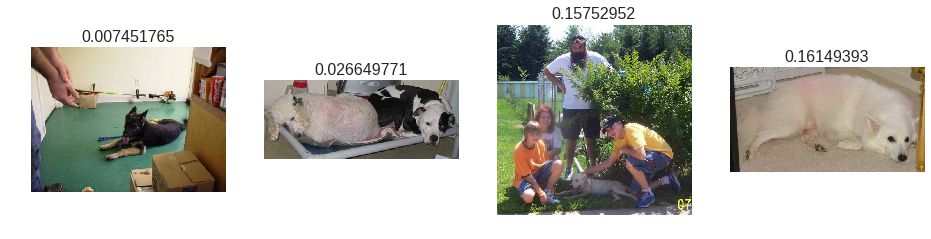

In [123]:
plot_val_with_title(most_correct(1, False), "Most incorrect dogs")